This notebook runs the code from this kaggle kernel [wingbeats-basic-py](https://www.kaggle.com/potamitis/wingbeats-basic-py), which is governed by Apache 2.0 license, copyright of Ilyas Potamitis.

The data comes from this kaggle dataset [Wingbeats](https://www.kaggle.com/potamitis/wingbeats/data).

The data collection process is described in the following paper:

[http://ieeexplore.ieee.org/abstract/document/7482663/](http://ieeexplore.ieee.org/abstract/document/7482663/)

In [1]:
# WINGBEATS DATABASE

from __future__ import division
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.utils import shuffle
from sklearn.metrics import accuracy_score
from sklearn.pipeline import make_pipeline

import librosa
import xgboost
import lightgbm as lgb

import pandas as pd
import numpy as np

from matplotlib import pyplot as plt
%matplotlib inline

import os
import soundfile as sf
from scipy import signal

import seaborn as sn

In [11]:
def get_data(target_names):

	# Read about 20K of recs from every species
	# Note: All wav files must be the same sampling frequency and number of datapoints!

	X = []                    # holds all data
	y = []                    # holds all class labels

	filenames = []            # holds all the file names
	target_count = []         # holds the counts in a class

	for i, target in enumerate(target_names):
	    target_count.append(0)  # initialize target count
	    path='data/Wingbeats/' + target + '/'    # assemble path string

	    for [root, dirs, files] in os.walk(path, topdown=False):
	        for filename in files:
	            name,ext = os.path.splitext(filename)
	            if ext=='.wav':
	                name=os.path.join(root, filename)
	                data, fs = sf.read(name)
	                X.append(data)
	                y.append(i)
	                filenames.append(name)
	                target_count[i]+=1
	                if target_count[i]>400:
	                	break
	    print (target,'#recs = ', target_count[i])

	X = np.vstack(X)
	y = np.hstack(y)

	X = X.astype("float32")
	print ("")
	print ("Total dataset size:")
	print ('# of classes: %d' % len(np.unique(y)))
	print ('total dataset size: %d' % X.shape[0])
	print ('Sampling frequency = %d Hz' % fs)
	print ("n_samples: %d" % X.shape[1])
	print ("duration (sec): %f" % (X.shape[1]/fs))

	return X, y

In [24]:
# main
fs = 100
target_names = ['Ae. aegypti', 'Ae. albopictus', 'An. gambiae', 'An. arabiensis', 'C. pipiens', 'C. quinquefasciatus']
#target_names = ['']

X, y = get_data(target_names)

# Just to be sure
X, y = shuffle(X,y, random_state=2018)
X.shape


Ae. aegypti #recs =  1258
Ae. albopictus #recs =  599
An. gambiae #recs =  891
An. arabiensis #recs =  590
C. pipiens #recs =  701
C. quinquefasciatus #recs =  1142

Total dataset size:
# of classes: 6
total dataset size: 5181
Sampling frequency = 8000 Hz
n_samples: 5000
duration (sec): 0.625000


(5181, 5000)

In [25]:
np.save('data/X.npy',X)
np.save('data/y.npy',y)

In [29]:
X = np.load('data/X.npy')
y = np.load('data/y.npy')

In [30]:
names = ["XGBoost", "Random Forest", "ExtraTreesClassifier", "Linear SVM", "RBF SVM"]

classifiers = [
	xgboost.XGBClassifier(n_estimators=650, learning_rate=0.2),
    RandomForestClassifier(n_estimators = 650, min_samples_split = 3, min_samples_leaf = 2, random_state = 2018, n_jobs=-1),
    ExtraTreesClassifier(n_estimators = 650, random_state = 2018, n_jobs=-1),
    SVC(kernel="linear", C=0.01),
    SVC(gamma=0.008, C=.1),]

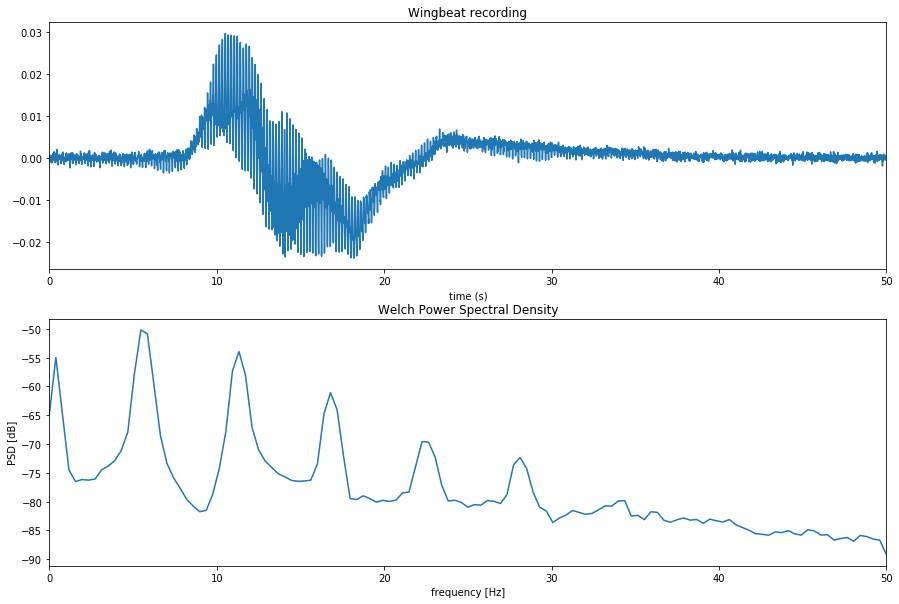

In [31]:
# transform the data
XX = np.zeros((X.shape[0],129)).astype("float32")   # allocate space
for i in range(X.shape[0]):
    XX[i] = 10*np.log10(signal.welch(X[i], fs=fs, window='hanning', nperseg=256, noverlap=128+64)[1])

# Show one recording
plt.figure(figsize = (15,10))
plt.subplot(2, 1, 1)
plt.plot(np.linspace(0,X.shape[1]/fs,X.shape[1]),X[0])
plt.autoscale(enable=True, axis='x', tight=True)
plt.xlabel('time (s)')
plt.title('Wingbeat recording')

plt.subplot(2, 1, 2)
plt.plot(np.linspace(0,fs/2,129),XX[0])
plt.autoscale(enable=True, axis='x', tight=True)
plt.xlabel('frequency [Hz]')
plt.ylabel('PSD [dB]')
plt.title('Welch Power Spectral Density')
plt.show()

In [32]:
# Mel-scale filterbank features
#XXX = np.zeros((X.shape[0],80)).astype("float32")   # allocate space
#for i in range(X.shape[0]):
#    XXX[i] = np.log10(np.mean(librosa.feature.melspectrogram(X[i], sr=fs, n_mels=80), axis=1))

In order to later evaluate the performance of the classifiers we split the dataset into a training and testing part, where the testing part is 20% of the total dataset. We use the `train_test_split` function for that.

In [33]:
# A quick result
X_train, X_test, y_train, y_test = train_test_split(XX, y, test_size=0.20, random_state=2018)
# fit model no training data
model = SVC(kernel = 'linear')
# model = xgboost.XGBClassifier(n_estimators=650, learning_rate=0.2)
model.fit(X_train, y_train)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='linear',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [34]:
# make predictions for test data
y_pred = model.predict(X_test)
ac = accuracy_score(y_test, y_pred)
print("Name: %s, ac: %f" % ('SVC', ac))

Name: SVC, ac: 0.680810


kernel classifier with rbf fails miserably???

In [23]:
#67 vs 73 (small dataset)

Empirical accuracy.
The accuracy of the classifier is defined as 
$\sum_{i=1}^N \mathbb{1}\{g(X_i)==Y_i\}/N$, i.e. we are counting for how many observations we predicted the correct label. The accuracy is an overall measure and it does not tell us where the error happens. It is often useful to look at the `confusion matrix` which contains different types of errors for each category.

Note, in general we observe samples from the joint distribution $(X,Y)$. The error of a classifier is $P(g(X) \ne Y)$

In [ ]:
# make predictions for test data
y_pred = model.predict(X_test)
ac = accuracy_score(y_test, y_pred)
print("Name: %s, ac: %f" % ('XGBoost', ac))

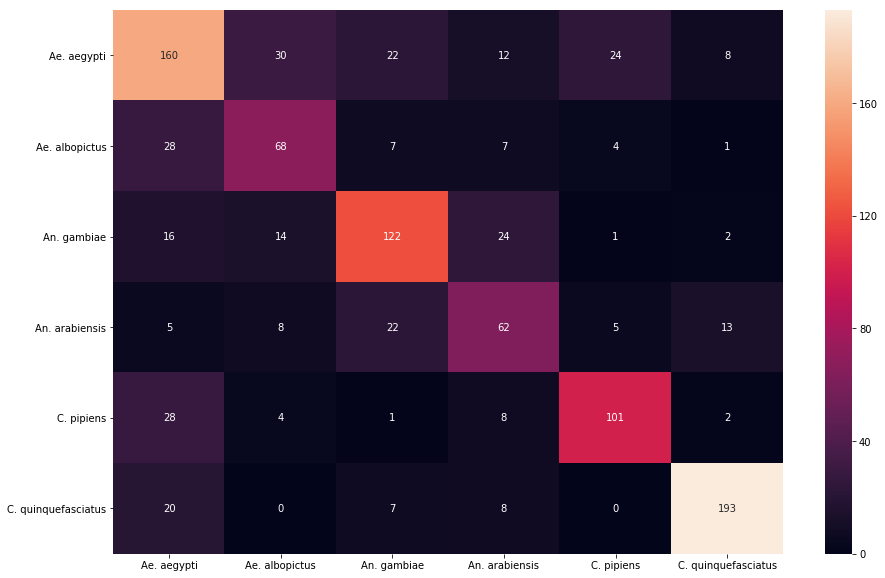

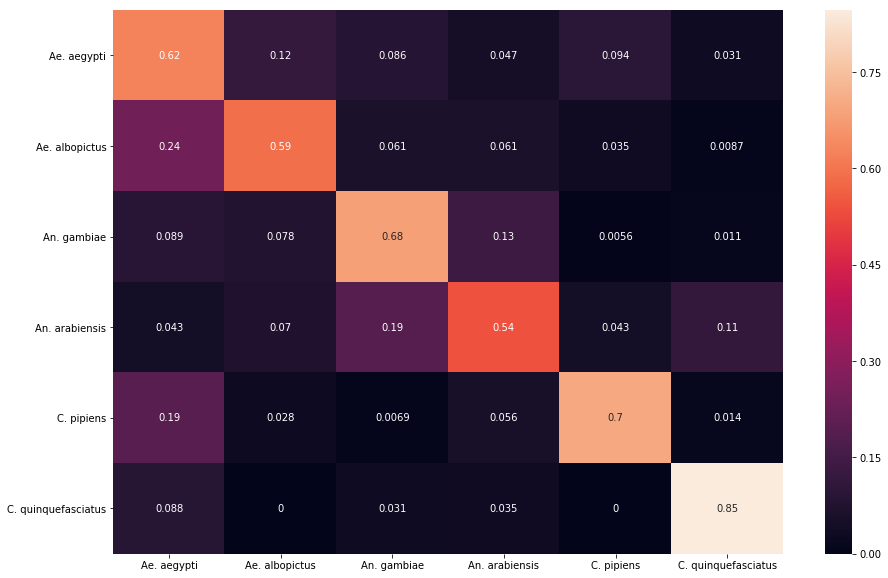

In [35]:
# Print the confusiona matrix
cm = confusion_matrix(y_test, y_pred)
df_cm = pd.DataFrame(cm, columns=target_names, index=target_names)
plt.figure(figsize = (15,10))
sn.heatmap(df_cm, annot=True, fmt="d")

print("")

cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
df_cm = pd.DataFrame(cm, columns=target_names, index=target_names)
plt.figure(figsize = (15,10))
sn.heatmap(df_cm, annot=True)
plt.show()

print("")

In [36]:
%%time
# CV experiments - it will take long..
# Species level
for name, clf in zip(names, classifiers):
	print(name)
	clf_ = make_pipeline(StandardScaler(), clf)
	acc_folds = cross_val_score(clf_, XX, y, cv=10)
	print("Mean: %f, Std: %f" % (np.mean(acc_folds), np.std(acc_folds)))
	print("")


#ac: 0.824167
params = {'task': 'train',
    'boosting_type': 'gbdt',
    'objective': 'multiclass',
    'num_class':6,
    'metric': 'multi_logloss',
    'learning_rate': 0.002296,
    'max_depth': 7,
    'num_leaves': 17,
    'feature_fraction': 0.4,
    'bagging_fraction': 0.6,
    'bagging_freq': 17}

# create dataset for lightgbm
lgb_train = lgb.Dataset(X_train, y_train)
lgb_eval = lgb.Dataset(X_test, y_test, reference=lgb_train)

# specify your configurations as a dict
#lgb_cv = lgb.cv(params, lgb_train, num_boost_round=10000, nfold=3, shuffle=True, stratified=True, verbose_eval=20, early_stopping_rounds=100)
#nround = lgb_cv['multi_logloss-mean'].index(np.min(lgb_cv['multi_logloss-mean']))
#print(nround)

gbm = lgb.train(params, lgb_train, num_boost_round=20000)
y_pred = np.argmax(gbm.predict(X_test),axis=1)

ac = accuracy_score(y_test, y_pred)
print("Name: %s, ac: %f" % ('LightGBM', ac))

XGBoost


/Users/valentina/anaconda/envs/wingbeats/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/valentina/anaconda/envs/wingbeats/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/valentina/anaconda/envs/wingbeats/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/valentina/anaconda/envs/wingbeats/lib/python3.6/site-packages/sklearn/preprocessing/

Mean: 0.771078, Std: 0.011481

Random Forest
Mean: 0.727073, Std: 0.020685

ExtraTreesClassifier
Mean: 0.722829, Std: 0.020770

Linear SVM
Mean: 0.679584, Std: 0.013797

RBF SVM
Mean: 0.654683, Std: 0.021324

Name: LightGBM, ac: 0.794600
CPU times: user 47min 3s, sys: 14.9 s, total: 47min 18s
Wall time: 1h 41min 23s


In [37]:
# 47 minutes

The performance of the XGBoost classifier is best. This is a generally quite robust nonlinear classifier and often outperforms Random Forests. The disadvantage is that it is more computationally expensive and harder to parallelize.